# Video Game Sales Model
### Goals
This project aims to answer 2 questions

* Rather the population size of a region has a relation to carbon emissions.
* Was there a significant effect on carbon emissions based on year and state

### Project Members:
* [Laurent Mundell](https://github.com/LaurentStar)
* [Joe Hart](https://github.com/joseh4)


### Table of Contents
    -Imports
    -Data Sources
    -Load Data
    -Methods/Globals/Constants
    -Explore Data Analysis
    -Explore Data Visuals
    -Data Prep
    -Modeling
    -Hypothesis Test I
    -Hypothesis Test II

* [Video Game Sales with Ratings](https://www.kaggle.com/rush4ratio/video-game-sales-with-ratings)
* [Google Trends work around](https://www.quora.com/How-can-I-see-absolute-search-number-volume-on-Google-Trends)
https://www.scikit-yb.org/en/latest/api/regressor/residuals.html

# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

import warnings
warnings.filterwarnings('ignore')

# Load Data

In [3]:
file_path  = os.path.join('data', 'Video_Games_Sales_as_at_22_Dec_2016.csv')
video_game_df = pd.read_csv(file_path)


# Drop all columns we aren't going to use
global_df = video_game_df.drop(['NA_Sales',
                            'EU_Sales', 
                            'JP_Sales', 
                            'Other_Sales', 
                            'Critic_Score',
                            'Critic_Count',
                            'User_Score',
                            'User_Count'], axis=1)

# Methods/Globals/Constants

In [4]:
%run -i "scripts//methods_globals_constants.py"

# Exploratory Data Analysis

In [6]:
"""
-Basic general statistics about the data.
-Rating appears to be missing many values
-Developer is also missing a large chuck of data
"""

# display(global_df.head())
# display(global_df.info())
# display(global_df.describe().T)
# print('Shape:', global_df.shape)

'\n-Basic general statistics about the data.\n-Rating appears to be missing many values\n-Developer is also missing a large chuck of data\n'

In [ ]:
"""
-Checking missing values by year of release.
-Total missing values are 6543 observations which ~ 40% of the data
"""
print(global_df.shape)
print(global_df[global_df.Developer.isna()].Year_of_Release.value_counts().sum())
print('missing data percentage', 
      (global_df[global_df.Developer.isna()].Year_of_Release.value_counts().sum()/global_df.shape[0])*100)
global_df[global_df.Developer.isna()].Year_of_Release.value_counts()

# Exploratory Data Visualization

In [ ]:
"""
- The boxplot reveal many outlier for each platform however it seems most outlier are positive
"""

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
sns.boxplot(x="Platform", y="Global_Sales", data=global_df, ax=ax[0])
sns.boxplot(x="Platform", y="Global_Sales", data=global_df[global_df["Global_Sales"]<=5], ax=ax[1]);

# Data Prep

In [7]:
"""
-Unable to identify developers and rating. classifying nan values as unknown for now
"""
global_df['Developer'].fillna('Unknown', inplace=True)
global_df['Rating'].fillna('Unknown', inplace=True)


"""
-Only two values missing from genre so we removed the rows
-Year_of-release has ~ 300 rows missing but this only 1.6% of the remaining observations so we removed them too. 
-The publisher had ~ 30 rows missing after removing the nan row. this is less than 1% of the remaining
 data so it was nans were removed
"""
global_df.dropna(subset=['Genre', 'Year_of_Release', 'Publisher'], inplace=True)


"""
- We made a new column of the len in characters for each game name to check if name len had an effect on global sales
- We also counted the number of words in each name for the same purpose
"""
global_df['Name_Character_Length'] = global_df['Name'].map(lambda name : len(name))
global_df['Name_Word_Count'] = global_df['Name'].map(lambda name : len(name.split()))


"""
- A decision was made to model after plaforms released 2007 and onward and to exclude handhelds.
- DC (DreamCast) is a special exception 
"""
_ = ((global_df['Year_of_Release'] > 2007) 
     & (global_df['Platform'].isin(['DC', 'DS', 'GB', 'PSP', '3DS', 'PSV']) == False))
global_df = global_df[_]


"""
One hot encoding three catagorical columns because they don't have too many unique values
"""
_ = pd.get_dummies(global_df['Rating'], drop_first=True)
global_df = pd.concat([global_df, _], axis=1)

_ = pd.get_dummies(global_df['Genre'], drop_first=True)
global_df = pd.concat([global_df, _], axis=1)

_ = pd.get_dummies(global_df['Platform'], drop_first=True)
global_df = pd.concat([global_df, _], axis=1)


"""
Drop all columns not needed to build models
"""
global_df.drop(columns=['Developer', 'Name', 'Platform', 'Rating'], inplace=True)

# Modeling

In [13]:
X = global_df

y = global_df['Global_Sales']

log_y = np.log(y)

In [14]:
#Breaking the law for the presentation, Data leak here.... please fix later

X['Publisher_Avg'] = X['Publisher']
X['Genre_Avg'] = X['Genre']

for publisher in X['Publisher'].unique():
    mean = X[X['Publisher_Avg'] == publisher]['Global_Sales'].mean()
    X['Publisher_Avg'] = X['Publisher_Avg'].replace(to_replace = publisher, value=mean)
    
for genre in X['Genre'].unique():
    mean = X[X['Genre_Avg'] == genre]['Global_Sales'].mean()
    X['Genre_Avg'] = X['Genre_Avg'].replace(to_replace = genre, value=mean) 
    
X.drop(columns=['Publisher','Global_Sales', 'Genre'], inplace=True)

In [15]:
 X_train, X_test, y_train, y_test = train_test_split(X, log_y, test_size= 0.2)

In [18]:
y_test.shape, y_train.shape, X_test.shape, X_train.shape

((1005,), (4016,), (1005, 29), (4016, 29))

In [ ]:
# """
# - Make a copy of publisher & Genre column and iteratively alter it until you contain mean avg values by publisher and genre.
# - After completion remove the Publisher(Not model ready), Global_Sales(Target) columns, Genre(Not model ready)
# """

# X_train['Publisher_Avg'] = X_train['Publisher']
# X_train['Genre_Avg'] = X_train['Genre']

# for publisher in X_train['Publisher'].unique():
#     mean = X_train[X_train['Publisher_Avg'] == publisher]['Global_Sales'].mean()
#     X_train['Publisher_Avg'] = X_train['Publisher_Avg'].replace(to_replace = publisher, value=mean)
    
# for genre in X_train['Genre'].unique():
#     mean = X_train[X_train['Genre_Avg'] == genre]['Global_Sales'].mean()
#     X_train['Genre_Avg'] = X_train['Genre_Avg'].replace(to_replace = genre, value=mean)    
    
# X_train.drop(columns=['Publisher','Global_Sales', 'Genre'], inplace=True)
# X_test.drop(columns=['Publisher','Global_Sales', 'Genre'], inplace=True)

In [ ]:
lr = LinearRegression()

In [ ]:
lr.fit(X_train, y_train)

In [ ]:
y_pred = lr.predict(X_train)
res = y_train - y_pred 

In [ ]:
plt.scatter(y_train, y_pred);

In [ ]:
plt.scatter(y_pred, res);

# Interactions

In [ ]:
list(enumerate(X_train.columns))

In [17]:
target = 'Adventure'
interact = X_train.columns[19:27]
adventure_IN_platoform_df = build_interaction(X_train.copy(), target, interact)

In [19]:
action_platform_inter = LinearRegression()
action_platform_inter.fit(adventure_IN_platoform_df, y_train)
y_pred = action_platform_inter.predict(adventure_IN_platoform_df)
res = y_train - y_pred 

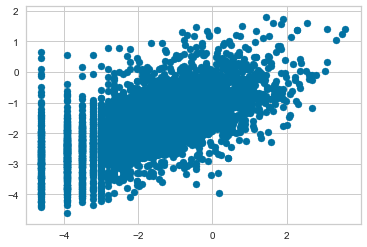

In [20]:
plt.scatter(y_train, y_pred)

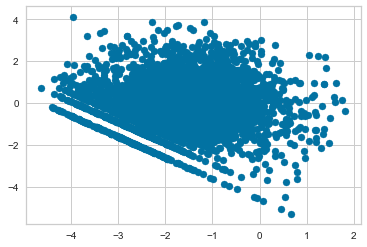

In [21]:
plt.scatter(y_pred, res)

In [22]:
y_test.shape, y_train.shape, X_test.shape, X_train.shape

((1005,), (4016,), (1005, 29), (4016, 29))

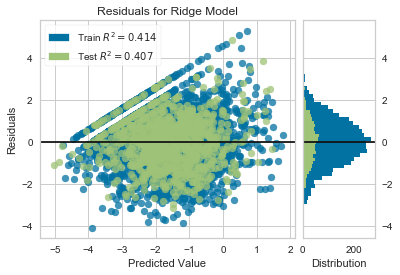

In [25]:
model = Ridge()
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

# Cleaned Data Exploratory Visual

In [ ]:
"""
By the year 2000 there was no signicant online present for metacritic. Below games released before 1995 were removed.
"""
print('Dataframe with filled nan values')
sns.pairplot(video_game_null_fill_df);

In [ ]:
"""
Critic score and count are strongly correlated suggesting the number of critque averages out the game's score
"""
fig, ax = plt.subplots(figsize=(15,8))  
sns.heatmap(video_game_null_fill_df.corr(), annot=True, ax=ax);

In [ ]:
"""
The User scores and critic score are on different scales being 0-10 and 0-100 respectfully. 
Dispite this the distrubtions do look normal so critics and users may review the same way
"""
fig, ax = plt.subplots(figsize=(15,8))  

ax.hist(video_game_null_fill_df['Critic_Score'])
ax.hist(video_game_null_fill_df['User_Score']);

In [ ]:
"""
The critics total of reviews per game is so small compared to count of user reviews,
the critics histogram doesn't appear at all. One thing about them is their skewness to the left. 
Both have the same form of skewness where for a particular game there are way more than normal
"""

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,8))  

ax[0].hist(video_game_null_fill_df['Critic_Count'])
ax[0].hist(video_game_null_fill_df['User_Count'])

ax[1].hist(video_game_null_fill_df['Critic_Count']);;

In [ ]:
"""
Oh no..... What 
"""

fig, ax = plt.subplots(figsize=(15,8))  

ax.bar(x = video_game_null_fill_df['Year_of_Release'], height = video_game_null_fill_df['Critic_Count']);

In [ ]:
video_game_null_fill_df[video_game_null_fill_df['Year_of_Release'] == 2020]

# Encoding

In [ ]:
_ = pd.get_dummies(video_game_null_fill_df[['Platform']], drop_first=True)
list(pd.concat([video_game_null_fill_df, _], axis=1, sort=False).columns)[12:].sort()

In [ ]:
print(video_game_null_fill_df['Platform'].unique())
print(video_game_null_fill_df['Platform'].shape)

# Scaling/Normalizing Data

In [ ]:
video_game_df[feat].map(lambda x: np.log(x))

In [ ]:
# Min-Max scaling User score and Critic score for interpretation

_ = video_game_null_fill_df['Critic_Score']
video_game_null_fill_df['Critic_Score'] = (_-min(_))/(max(_)-min(_))
video_game_null_fill_df['User_Score'] = (logcrim-min(logcrim))/(max(logcrim)-min(logcrim))
boston_features['DIS'] = (logdis-min(logdis))/(max(logdis)-min(logdis))



data = [[-1, 2], [-0.5, 6], [0, 10], [1, 18]]
>>> scaler = MinMaxScaler()
>>> print(scaler.fit(data))
MinMaxScaler()
>>> print(scaler.data_max_)
[ 1. 18.]
>>> print(scaler.transform(data))
[[0.   0.  ]
 [0.25 0.25]
 [0.5  0.5 ]
 [1.   1.  ]]
>>> print(scaler.transform([[2, 2]]))
[[1.5 0. ]]

# [Video Game]
#### Data World 
    *https://data.world/craigkelly/steam-game-data
    [Shareholder] They are a publisher, they want buy a new team but want to make sure they make good choice
        [Question1] Can we build a predict/regression model to predict a potential interval for steamspyowners? 
        [Question2] Metacritic scores are from 0 -100. Could we build a classifer model?
#### Kaggle
	*https://www.kaggle.com/gregorut/videogamesales
	*https://www.kaggle.com/rush4ratio/video-game-sales-with-ratings
	*https://www.kaggle.com/kendallgillies/video-game-sales-and-ratings
     [Shareholder] They are a publisher is looking for recommendations for what types of game to make
         [Question1] Can we pridict Global_Sales


# [Animals]
##### Kaggle 
    *https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-outcomes-and
    [Shareholder] ?????
    
    [Not Enough]https://www.kaggle.com/mbogernetto/brazilian-amazon-rainforest-degradation
    [Not independent]https://www.kaggle.com/se18m502/bee-hive-metrics#weight_2017.csv
    [Not independent]https://www.kaggle.com/hocop1/cat-and-dog-breeds-parameters
    [Not independent]https://www.kaggle.com/jessicali9530/honey-production
    
# [Medical]
##### Kaggle
    [Not independent]https://www.kaggle.com/de5d5fe61fcaa6ad7a66/coronavirus-dataset-update-0206

# [Vehicle]
##### Data World
    https://data.world/nhtsa/nhtsas-odi-recalls/workspace/project-summary?agentid=nhtsa&datasetid=nhtsas-odi-recalls

##### Kaggle
    https://www.kaggle.com/austinreese/craigslist-carstrucks-data
    [ShareHolder] A small start up want to build an app to help people buy better cars off craiglist. 
        [Question1] Can we classify the cars by title_status?
        [Question2] Can we predict the odometer for the car?
        [Question3] Can we classify condition
        
    *https://www.kaggle.com/mirosval/personal-cars-classifieds
    [ShareHolder] Find cars for people app
        [Question]The user get an estimate of price_eur based on car details
        
# [Misc]
##### Buzzfeed
    *https://github.com/BuzzFeedNews/2014-06-firework-injuries
    [Shareholder] We're an evil insurance company, which collection of people should we raise the price? 
    [Question]
    
    *https://www.kaggle.com/rusiano/snooker-data-19822020#players_r.csv

In [ ]:
# #Fill all nan value with the average by genre
# video_game_null_fill_df = video_game_null_fill_df.apply(lambda x : fillna_average_by_target_column(x, GENRE_CRITIC_SCORE_AVG, 3, 10),  axis=1)


# video_game_null_fill_df = video_game_null_fill_df.apply(lambda x : fillna_average_by_target_column(x, GENRE_CRITIC_COUNT_AVG, 3, 11),  axis=1)
# video_game_null_fill_df = video_game_null_fill_df.apply(lambda x : fillna_average_by_target_column(x, GENRE_USER_SCORE_AVG, 3, 12),  axis=1)
# video_game_null_fill_df = video_game_null_fill_df.apply(lambda x : fillna_average_by_target_column(x, GENRE_CRITIC_COUNT_AVG, 3, 13),  axis=1)

# #Drop all related sales columns
# video_game_null_fill_df.drop(columns=['EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], inplace=True)

# #Drop all release year Nan  rows Appoximity ~ 300 rows
# #video_game_null_fill_df.dropna(subset=['Year_of_Release', 'Genre'], inplace=True)

# # Make release a simple int type to represent it more accuracly 
# video_game_null_fill_df['Year_of_Release'] = video_game_null_fill_df['Year_of_Release'].astype(int)

# # Convert user score to float to represent accurately
# video_game_null_fill_df['User_Score'] = video_game_null_fill_df['User_Score'].astype(float)

# # Drop all observation below the year 1990
# video_game_null_fill_df = video_game_null_fill_df[video_game_null_fill_df['Year_of_Release'] > 1995]